In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gamma
from scipy.stats import ortho_group

import cupy as cp
import cupyx.scipy 

from Test.hsic_naive import IndpTest_naive
from Test.hsic_lkgau import IndpTest_LKGaussian
from Test.hsic_lklap import IndpTest_LKLaplace
from Test.hsic_lkwgau import IndpTest_LKWeightGaussian
from Test.hsic_lkwlap import IndpTest_LKWeightLaplace
from Test.hsic_lkselect import IndpTest_LKSelect_GauLap
from Test.hsic_kselect import IndpTest_KSelect
from Test.dime_gaussian import IndpTest_DIME
from Test.mbmi_gaussian import IndpTest_kernelMI

device = torch.device('cuda:0')

In [73]:
def generate_ISA(n,d,sigma_normal,alpha, seed):
    np.random.seed(seed)
    x = np.concatenate((np.random.normal(-1, sigma_normal, n//2), np.random.normal(1, sigma_normal, n//2)))
    y = np.concatenate((np.random.normal(-1, sigma_normal, n//2), np.random.normal(1, sigma_normal, n//2)))
    p = np.random.permutation(n)
    y_p = y[p]

    D = np.zeros([2,n])
    D[0,:] = x
    D[1,:] = y_p

    theta = np.pi/4*alpha
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    D_R = R@D
    X_mix = D_R[0,:].reshape(-1,1)
    Y_mix = D_R[1,:].reshape(-1,1)

    X_z = np.random.randn(n,d-1)
    Y_z = np.random.randn(n,d-1)

    X_con = np.concatenate((X_mix,X_z), axis=1)
    Y_con = np.concatenate((Y_mix,Y_z), axis=1)

    m_x = ortho_group.rvs(dim=d)
    m_y = ortho_group.rvs(dim=d)

    X = (m_x@X_con.T).T
    Y = (m_y@Y_con.T).T
    
    return X,Y

def Sinusoid(x, y, w):
    return 1 + np.sin(w*x)*np.sin(w*y)

def Sinusoid_Generator(n,w, seed = 0):
    np.random.seed(seed)
    i = 0
    output = np.zeros([n,2])
    while i < n:
        U = np.random.rand(1)
        V = np.random.rand(2)
        x0 = -np.pi + V[0]*2*np.pi
        x1 = -np.pi + V[1]*2*np.pi
        if U < 1/2 * Sinusoid(x0,x1,w):
            output[i, 0] = x0
            output[i, 1] = x1
            i = i + 1
    X = output[:,0:1]
    Y = output[:,1:]
    return X,Y

# n = 1000
# d = 3
def sinedependence(n,d,seed = 0):
    np.random.seed(seed)
    mean = np.zeros(d)
    cov = np.eye(d)
    X = np.random.multivariate_normal(mean, cov, n)
    Z = np.random.randn(n)
    Y = 20*np.sin(4*np.pi*(X[:,0]**2 + X[:,1]**2))+Z 
    return X,Y

# n = 1000
# d = 4
def GSign(n,d, seed):
    np.random.seed(seed)
    mean = np.zeros(d)
    cov = np.eye(d)
    X = np.random.multivariate_normal(mean, cov, n)
    sign_X = np.sign(X)
    Z = np.random.randn(n)
    Y = np.abs(Z)*np.prod(sign_X,1)
    return X,Y



Max DiME_n: 3.042466229952625
sigma_x: 1.0448219776153564, sigma_y: 21.275083541870117
Dime alpha = 1.0, diagonal kernel
threshold:  0.02108719207300966 DiME 0.027750316818098142 null rejected: True
1 [1. 0. 0. 0. 0. 0.]
Max DiME_n: 1.895966227804232
sigma_x: 0.1322661191225052, sigma_y: 21.508291244506836
Dime alpha = 1.0, diagonal kernel
threshold:  0.02304349354001668 DiME 0.06190680778155766 null rejected: True
2 [1. 0. 0. 0. 0. 0.]
Max DiME_n: 1.2415776829909213
sigma_x: 1.031802773475647, sigma_y: 0.33490514755249023
Dime alpha = 1.0, diagonal kernel
threshold:  0.021077113110798868 DiME 0.034212454225219346 null rejected: True
3 [1. 0. 0. 0. 0. 0.]
Max DiME_n: 2.0740525012483073
sigma_x: 0.1304669827222824, sigma_y: 21.305238723754883
Dime alpha = 1.0, diagonal kernel
threshold:  0.02236547105303215 DiME 0.040340369186461444 null rejected: True
4 [1. 0. 0. 0. 0. 0.]
Max DiME_n: 4.778110373676166
sigma_x: 0.35997331142425537, sigma_y: 21.327720642089844
Dime alpha = 1.0, diagonal

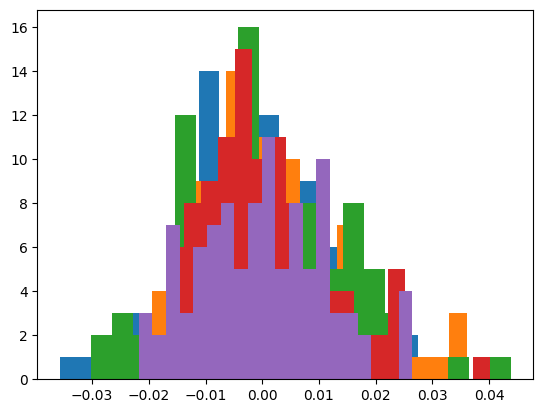

In [65]:
n = 600
d = 3
test_num = 5
dime_perm = 10
result_test_correct = np.zeros([6,test_num])
seed = 0 
for it in range(test_num):
    X, Y = sinedependence(n, d, seed)
    Y = Y.reshape(-1,1)
    X_tensor, Y_tensor = torch.tensor(X, device=device), torch.tensor(Y,device=device)

    #test#

  
    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 10, alpha = 1.0, type_bandwidth="weighted", lr = 0.05,  split_ratio = 0.5, 
                                    batch_size = None, grid_search_min = -3, grid_search_max = 3, epochs=300)
    results_dime = dime_estimator.perform_test()
    result_test_correct[0, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 1.0, diagonal kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected:' ,results_dime["h0_rejected"].item())
    # print(dime_estimator.sigma_x_diag_vals)

    seed += 1
    print(it+1, np.sum(result_test_correct,1)/(it+1))

Max DiME_n: 2.943247982297461
sigma_x: 7.62971305847168, sigma_y: 7.509029865264893
Dime alpha = 1.0, diagonal kernel
threshold:  0.007781089056117338 DiME 0.007828506330203489 null rejected: True
1 [1. 0. 0. 0. 0. 0.]
Max DiME_n: 2.413542917605177
sigma_x: 0.34139391779899597, sigma_y: 7.635970592498779
Dime alpha = 1.0, diagonal kernel
threshold:  0.035127281464932374 DiME 0.06040520730254606 null rejected: True
2 [1. 0. 0. 0. 0. 0.]
Max DiME_n: 5.111304136166503
sigma_x: 0.334937185049057, sigma_y: 0.12203031033277512
Dime alpha = 1.0, diagonal kernel
threshold:  0.036115706911608626 DiME 0.07619466887045068 null rejected: True
3 [1. 0. 0. 0. 0. 0.]
Max DiME_n: 5.179522498147192
sigma_x: 0.12071298062801361, sigma_y: 0.3394920825958252
Dime alpha = 1.0, diagonal kernel
threshold:  0.03487790203754439 DiME 0.033398615333068093 null rejected: False
4 [0.75 0.   0.   0.   0.   0.  ]
Max DiME_n: 3.810804419372681
sigma_x: 0.9278213381767273, sigma_y: 0.34090951085090637
Dime alpha = 1.0

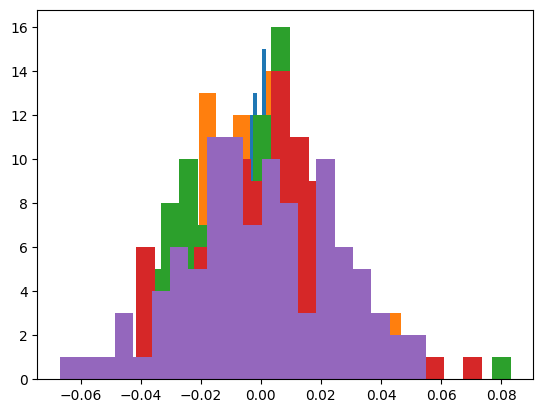

In [74]:
test_num = 5
dime_perm = 10
result_test_correct = np.zeros([6,test_num])
seed = 0 
for it in range(test_num):
    w = 3
    n = 400
    X, Y = Sinusoid_Generator(n, w, seed)
    Y = Y.reshape(-1,1)
    X_tensor, Y_tensor = torch.tensor(X, device=device), torch.tensor(Y,device=device)

    #test#

  
    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 10, alpha = 1.0, type_bandwidth="weighted", lr = 0.05,  split_ratio = 0.5, 
                                    batch_size = None, grid_search_min = -3, grid_search_max = 3, epochs=300)
    results_dime = dime_estimator.perform_test()
    result_test_correct[0, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 1.0, diagonal kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected:' ,results_dime["h0_rejected"].item())
    # print(dime_estimator.sigma_x_diag_vals)

    seed += 1
    print(it+1, np.sum(result_test_correct,1)/(it+1))

In [7]:
dime_estimator.sigma_x_diag_vals

tensor([0.1065, 0.0945, 0.2988], device='cuda:0', dtype=torch.float64)

In [74]:
sample_sizes = (300,600,900,1200)
n_samples = len(sample_sizes)
n_tests = 9
test_num = 5
result_test_correct = np.zeros([n_tests,n_samples, test_num])
print(result_test_correct.shape)

(9, 4, 5)


In [ ]:
n = 400
d = 4
test_num = 10

result_test_correct = np.zeros([6,test_num])
seed = 0 
for it in range(test_num):
    
    X, Y = GSign(n,d, seed)
    Y = Y.reshape(-1,1)
    X_tensor, Y_tensor = torch.tensor(X, device=device), torch.tensor(Y,device=device)

    #test#
    
    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 1.0, isotropic = True)
    results_dime = dime_estimator.perform_test()
    result_test_correct[0, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 1.0, isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected:' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 1.0, isotropic = False)
    results_dime = dime_estimator.perform_test()
    result_test_correct[1, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 1.0, non-isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 2.0, isotropic = True)
    results_dime = dime_estimator.perform_test()
    result_test_correct[2, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 2.0, isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 2.0, isotropic = False)
    results_dime = dime_estimator.perform_test()
    result_test_correct[3, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 2.0, non-isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 5.0, isotropic = True)
    results_dime = dime_estimator.perform_test()
    result_test_correct[4, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 5.0, isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 5.0, isotropic = False)
    results_dime = dime_estimator.perform_test()
    result_test_correct[5, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 5.0, non-isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    seed += 1
    print(it+1, np.sum(result_test_correct,1)/(it+1))

Max DiME_n: 3.503398728476949
sigma_x: 0.40128645300865173, sigma_y: 0.6782501935958862
Dime alpha = 1.0, non-isotropic kernel
threshold:  0.009281500480336689 DiME 0.020671788916128975 null rejected True
1 [1. 0. 0. 0. 0. 0.]
Max DiME_n: 2.8560625144490577
sigma_x: 0.4083666205406189, sigma_y: 0.6739561557769775
Dime alpha = 1.0, non-isotropic kernel
threshold:  0.012878094873351963 DiME 0.024481010562684702 null rejected True
2 [1. 0. 0. 0. 0. 0.]
Max DiME_n: 8.423985331651757
sigma_x: 0.39946532249450684, sigma_y: 1.9508001804351807
Dime alpha = 1.0, non-isotropic kernel
threshold:  0.0082700022433428 DiME 0.01323525950581761 null rejected True
3 [1. 0. 0. 0. 0. 0.]
Max DiME_n: 4.357521820325497
sigma_x: 1.142253041267395, sigma_y: 5.345169544219971
Dime alpha = 1.0, non-isotropic kernel
threshold:  0.010523739965951994 DiME 0.021728435755274944 null rejected True
4 [1. 0. 0. 0. 0. 0.]
Max DiME_n: 4.312733419587867
sigma_x: 3.2035300731658936, sigma_y: 1.9094562530517578
Dime alpha 

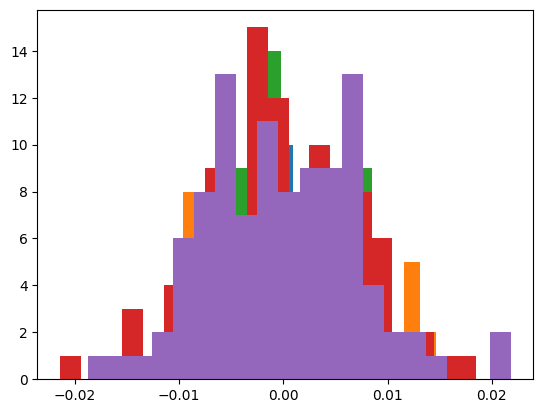

In [69]:
n = 600
d = 4
test_num = 5

result_test_correct = np.zeros([6,test_num])
seed = 0 
for it in range(test_num):
    
    X, Y = GSign(n,d, seed)
    Y = Y.reshape(-1,1)
    X_tensor, Y_tensor = torch.tensor(X, device=device), torch.tensor(Y,device=device)

    #test#
    
    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 1.0, isotropic = True)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[0, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 1.0, isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected:' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 10, alpha = 0.5, type_bandwidth="weighted", lr = 0.05,  split_ratio = 0.5, 
                                    batch_size = None, grid_search_min = -3, grid_search_max = 3, epochs=300)
    results_dime = dime_estimator.perform_test()
    result_test_correct[0, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 1.0, non-isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    seed += 1
    print(it+1, np.sum(result_test_correct,1)/(it+1))

In [93]:
torch.linspace(-2, 2, 5)

tensor([-2., -1.,  0.,  1.,  2.])

In [6]:
# ica experiments #

test_num = 100
result_all_correct = []

# alpha_set = np.linspace(0.0, 1.0, num=10)
alpha_set = [0.7]

confident_level = 0.05

for alpha in alpha_set:
    result_test_correct = np.zeros([3,test_num])
    
    for it in range(test_num):
        n = 128
        d = 4
        sigma_normal = 0.1
        X, Y = generate_ISA(n,d,sigma_normal,alpha)
        X_tensor, Y_tensor = torch.tensor(X), torch.tensor(Y)
        
        #test#
        hsic0 = IndpTest_naive(X_tensor, Y_tensor, alpha=0.05, n_permutation=100, kernel_type="Gaussian", null_gamma = True)
        results_all0 = hsic0.perform_test()
        result_test_correct[0, it] = float(results_all0['h0_rejected'])

        hsic1 = IndpTest_LKGaussian(X_tensor, Y_tensor, device, alpha=0.05, n_permutation=100, null_gamma = True, split_ratio = 0.5)
        results_all1 = hsic1.perform_test(debug = -1, if_grid_search = True)
        result_test_correct[1, it] = float(results_all1['h0_rejected'])

        hsic2 = IndpTest_LKWeightGaussian(X_tensor, Y_tensor, device, alpha=0.05, n_permutation=100, null_gamma = True, split_ratio = 0.5)
        results_all2 = hsic2.perform_test(debug = -1, if_grid_search = True)
        result_test_correct[2, it] = float(results_all2['h0_rejected'])

        print(alpha, it, np.sum(result_test_correct,1)/(it+1))
    
    result_all_correct.append(result_test_correct)

0.7 0 [1. 1. 1.]
0.7 1 [0.5 0.5 1. ]
0.7 2 [0.33333333 0.33333333 1.        ]
0.7 3 [0.25 0.5  1.  ]
0.7 4 [0.2 0.4 0.8]
0.7 5 [0.16666667 0.33333333 0.83333333]
0.7 6 [0.14285714 0.28571429 0.85714286]
0.7 7 [0.125 0.25  0.875]
0.7 8 [0.11111111 0.22222222 0.88888889]
0.7 9 [0.1 0.3 0.9]
0.7 10 [0.09090909 0.27272727 0.90909091]
0.7 11 [0.08333333 0.25       0.91666667]
0.7 12 [0.07692308 0.30769231 0.92307692]
0.7 13 [0.14285714 0.35714286 0.92857143]
0.7 14 [0.13333333 0.33333333 0.93333333]
0.7 15 [0.125  0.3125 0.875 ]
0.7 16 [0.11764706 0.29411765 0.88235294]
0.7 17 [0.11111111 0.27777778 0.88888889]
0.7 18 [0.10526316 0.31578947 0.89473684]
0.7 19 [0.1 0.3 0.9]
0.7 20 [0.0952381  0.33333333 0.9047619 ]
0.7 21 [0.09090909 0.36363636 0.90909091]
0.7 22 [0.08695652 0.34782609 0.91304348]
0.7 23 [0.08333333 0.375      0.91666667]
0.7 24 [0.08 0.36 0.92]
0.7 25 [0.07692308 0.38461538 0.88461538]
0.7 26 [0.11111111 0.40740741 0.88888889]
0.7 27 [0.10714286 0.42857143 0.89285714]
0.7 2

0.7
Max DiME_n: 27.72002430634668
sigma_x: 0.14499031007289886, sigma_y: 0.5506618022918701
Dime alpha = 1.0, diagonal kernel
threshold:  0.030107746998351823 DiME 0.07031591643912849 null rejected: True
1 [1. 0.]
Max DiME_n: 3.3249827287092217
sigma_x: 0.5731444358825684, sigma_y: 1.1251578330993652
Dime alpha = 1.0, diagonal kernel
threshold:  0.029930654891934468 DiME 0.11260303769773339 null rejected: True
2 [1. 0.]
Max DiME_n: 22.523204679363893
sigma_x: 0.29870057106018066, sigma_y: 0.14153744280338287
Dime alpha = 1.0, diagonal kernel
threshold:  0.02913115134165136 DiME 0.0857825817898159 null rejected: True
3 [1. 0.]
Max DiME_n: 3.06406145017665
sigma_x: 2.270512580871582, sigma_y: 0.5662457942962646
Dime alpha = 1.0, diagonal kernel
threshold:  0.028673667502594122 DiME 0.0882945147911176 null rejected: True
4 [1. 0.]
Max DiME_n: 3.516916213215107
sigma_x: 0.5659272074699402, sigma_y: 2.283562183380127
Dime alpha = 1.0, diagonal kernel
threshold:  0.038703247707052794 DiME 0.

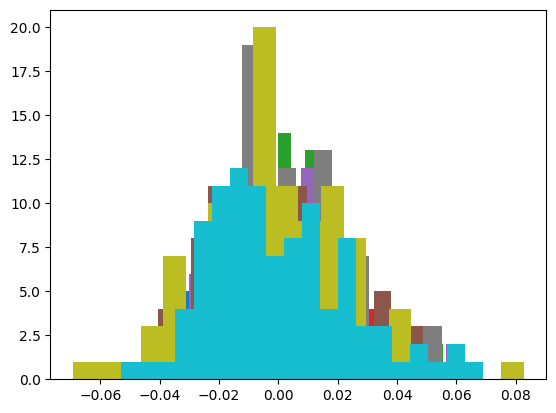

In [62]:

alphas = (0.7,)
alpha = alphas[0]
print(alpha)
n_alphas = len(alphas)
test_num = 10
dime_perm = 2
result_test_correct = np.zeros([2,test_num])
seed = 0 
sigma_normal = 0.1
n = 128
d = 4
for it in range(test_num):
    X, Y = generate_ISA(n,d,sigma_normal,alpha, seed)
    X_tensor, Y_tensor = torch.tensor(X, device=device), torch.tensor(Y,device=device)

    #test#
    
    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = dime_perm, alpha = 1.0, isotropic = True)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[0, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 1.0, isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected:' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME(X_tensor, Y_tensor, dime_perm = 10, alpha = 1.0, type_bandwidth = "weighted", lr = 0.005,  split_ratio = 0.5, 
                                    batch_size = None, grid_search_min = -3, grid_search_max = 1, epochs=300, scheduler=False, optimizer = "adam")
    results_dime = dime_estimator.perform_test()
    result_test_correct[0, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 1.0, diagonal kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected:' ,results_dime["h0_rejected"].item())

    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 2.0, isotropic = True)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[2, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 2.0, isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 2.0, isotropic = False)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[3, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 2.0, non-isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 5.0, isotropic = True)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[4, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 5.0, isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 5.0, isotropic = False)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[5, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 5.0, non-isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    # hsic0 = IndpTest_naive(X_tensor, Y_tensor, alpha=0.05, n_permutation=100, kernel_type="Gaussian", null_gamma = True)
    # results_all0 = hsic0.perform_test()
    # result_test_correct[0, it] = float(results_all0['h0_rejected'])

    # hsic1 = IndpTest_LKGaussian(X_tensor, Y_tensor, device, alpha=0.05, n_permutation=100, null_gamma = True, split_ratio = 0.5)
    # results_all1 = hsic1.perform_test(debug = -1, if_grid_search = True)
    # result_test_correct[1, it] = float(results_all1['h0_rejected'])

    # hsic2 = IndpTest_LKWeightGaussian(X_tensor, Y_tensor, device, alpha=0.05, n_permutation=100, null_gamma = True, split_ratio = 0.5)
    # results_all2 = hsic2.perform_test(debug = -1, if_grid_search = True)
    # result_test_correct[2, it] = float(results_all2['h0_rejected'])

    seed += 1
    print(it+1, np.sum(result_test_correct,1)/(it+1))

In [2]:
_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}
# methods for sampling unconditionally/conditionally on a given factor
def get_index(factors):
  """ Converts factors to indices in range(num_data)
  Args:
    factors: np array shape [6,batch_size].
             factors[i]=factors[i,:] takes integer values in 
             range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

  Returns:
    indices: np array shape [batch_size].
  """
  indices = 0
  base = 1
  for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
    indices += factors[factor] * base
    base *= _NUM_VALUES_PER_FACTOR[name]
  return indices


def sample_batch_spheres(images, batch_size, fixed_factor_str = 'shape', fixed_factor_value = 2, seed = 0):
  """ Samples a batch of images of spheres, with
      the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: shape.
    fixed_factor_value: 2 for spheres. 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    X: images shape [batch_size,64*64*3]
    Y: orientation [batch_size]

  """
  np.random.seed(seed)
  fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
  factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
  for factor, name in enumerate(_FACTORS_IN_ORDER):
    num_choices = _NUM_VALUES_PER_FACTOR[name]
    factors[factor] = np.random.choice(num_choices, batch_size)
  factors[fixed_factor] = fixed_factor_value
  Y = factors[5]
  indices = get_index(factors)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  ims.reshape([batch_size, 64, 64, 3])
  X = ims.reshape([batch_size, 64*64*3])
  return X,Y

<KeysViewHDF5 ['images', 'labels']>
sample size: 64 repetition:  0
Max DiME_n: 3.055100679397583
sigma_x: 41.25846481323242, sigma_y: 3.999999761581421
Dime alpha = 1.0, diagonal kernel
threshold:  0.07356610149145126 DiME 0.3262364864349365 null rejected: True


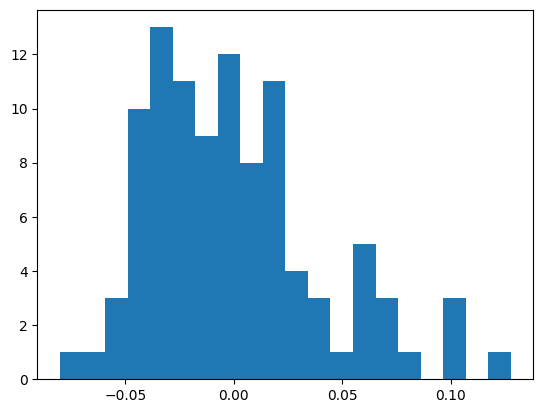

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
# load dataset
dataset = h5py.File('3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

repetitions = 5
# device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_sizes = (64,)
n_samples = len(sample_sizes)
test_num = 1
test_power = np.zeros([n_tests,n_samples, test_num])
seed = 0

for i, n in enumerate(sample_sizes):
    for j in range(test_num):
        print('sample size:', n, 'repetition: ', j)
        X, Y = sample_batch_spheres(images, batch_size = n, seed=seed)
        Y = Y.reshape(-1,1)
        Y = Y.astype(np.float32)
        X_tensor, Y_tensor = torch.tensor(X, device=device), torch.tensor(Y,device=device)

        # alpha = 1.0, von Neumann Entropies
        dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, alpha = 1.0, type_bandwidth= 'weighted',
                                        dime_perm =10 , lr = 0.05,
                                        epochs = 300, batch_size = None,
                                        grid_search_min = -3,
                                        grid_search_max = 3)
        results_dime = dime_estimator.perform_test()
        test_power[0, i, j] = float(results_dime['h0_rejected'])
        print('Dime alpha = 1.0, diagonal kernel')
        print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected:' ,results_dime["h0_rejected"].item())
        
        seed += 1

In [159]:
import matplotlib.colors as colors
def plot_pixel_weights(pixel_weights):
    # compute the average of channels
    pixel_weights = pixel_weights.reshape(64, 64, 3)
    pixel_weights = np.mean(pixel_weights, axis=2)

    plt.imshow(pixel_weights, cmap='viridis', interpolation='nearest', norm=colors.PowerNorm(gamma=0.3)) # bwr
    plt.colorbar()
    # plt.title(title)
    plt.axis('off')
    plt.show()

def plot_pixel_weights(pixel_weights):
    # compute the average of channels
    pixel_weights = pixel_weights.reshape(64, 64, 3)
    pixel_weights = np.mean(pixel_weights, axis=2)

    plt.imshow(pixel_weights, cmap='viridis', interpolation='nearest') # bwr
    plt.colorbar()
    # plt.title(title)
    plt.axis('off')
    plt.show()

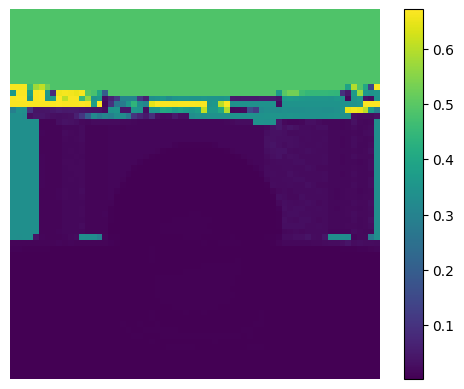

In [160]:
weight_x = torch.sigmoid(dime_estimator.att_x).cpu().detach().numpy()
# find values withing 0.45 adn 0.55 and make them 0
# weight_x[np.logical_and(weight_x>0.45, weight_x<0.55)] = 0 # these are values that were just irrelevant. 
plot_pixel_weights(weight_x)

array([[0.4916741 , 0.47930148, 0.48795748, ..., 0.00197943, 0.00242765,
        0.00265384]], dtype=float32)